In [1]:
#Loading Relevant Libraries
install.packages("kknn")
library(kknn)
install.packages("themis")
library(themis)
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()
── Attachi

In [5]:
set.seed(1000) 
#Reading in the Water Potability Dataset
water_pot_data <- read_csv("/home/jovyan/dsci_group_project_007/water_potability.csv")

#Factor Recoding Potability
water_pot_cleaned <- water_pot_data |>
    mutate(Potability = as_factor(Potability)) |>
    mutate(Potability = fct_recode(Potability, "Potable" = "1", "Unpotable" = "0"))

#Getting rid of NAs to compute correlation
water_pot_data_na <- water_pot_data |>
    drop_na()

#Selecting predictor variable based on correlation
pH_corr <- cor(water_pot_data_na)
pH_corr

#Solids and Turbidity have strongest correlation

#Checking Counts of variables
water_pot_count1 <- water_pot_cleaned |>
    select(Potability) |>
    filter(Potability == "Potable") |>
    summarize(Potable_Count = n())
water_pot_count1

water_pot_count <- water_pot_cleaned |>
    select(Potability) |>
    filter(Potability == "Unpotable") |>
    summarize(Unpotable_Count = n())

water_pot_count

Rows: 3276 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.00000000,0.10894811,-0.087614993,-0.024768491,0.010524348,0.014127848,0.028375219,0.018277876,-0.035848994,0.01453004
Hardness,0.10894811,1.00000000,-0.053268885,-0.022684975,-0.108520618,0.011730548,0.013223861,-0.015400382,-0.034830942,-0.00150502
Solids,-0.08761499,-0.05326888,1.000000000,-0.051789064,-0.162769204,-0.005197862,-0.005484046,-0.015667788,0.019409428,0.04067418
Chloramines,-0.02476849,-0.02268498,-0.051789064,1.000000000,0.006254057,-0.028276649,-0.023807630,0.014989930,0.013136570,0.02078361
Sulfate,0.01052435,-0.10852062,-0.162769204,0.006254057,1.000000000,-0.016192287,0.026775563,-0.023346904,-0.009933881,-0.01530315
Conductivity,0.01412785,0.01173055,-0.005197862,-0.028276649,-0.016192287,1.000000000,0.015646727,0.004888475,0.012494892,-0.01549572
Organic_carbon,0.02837522,0.01322386,-0.005484046,-0.023807630,0.026775563,0.015646727,1.000000000,-0.005667486,-0.015428291,-0.01556703
Trihalomethanes,0.01827788,-0.01540038,-0.015667788,0.014989930,-0.023346904,0.004888475,-0.005667486,1.000000000,-0.020497369,0.00924411
Turbidity,-0.03584899,-0.03483094,0.019409428,0.013136570,-0.009933881,0.012494892,-0.015428291,-0.020497369,1.000000000,0.02268240
Potability,0.01453004,-0.00150502,0.040674182,0.020783607,-0.015303149,-0.015495723,-0.015567030,0.009244110,0.022682396,1.00000000


Potable_Count
<int>
1278


Unpotable_Count
<int>
1998


In [6]:
set.seed(1000) 
#Rebalancing the Data
ups_recipe <- recipe(Potability ~ Solids + Turbidity, data = water_pot_cleaned) |>
  step_upsample(Potability, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

upsampled_water <- bake(ups_recipe, water_pot_cleaned)

#Looking at rebalanced count of potability classifications
upsampled_water |>
  group_by(Potability) |>
  summarize(n = n())

upsampled_water

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 3276 data points and no missing data.

Operations:

Up-sampling based on Potability [trained]

Potability,n
<fct>,<int>
Unpotable,1998
Potable,1998


Solids,Turbidity,Potability
<dbl>,<dbl>,<fct>
20791.32,2.963135,Unpotable
18630.06,4.500656,Unpotable
19909.54,3.055934,Unpotable
22018.42,4.628771,Unpotable
17978.99,4.075075,Unpotable
28748.69,2.559708,Unpotable
28749.72,2.672989,Unpotable
13672.09,4.401425,Unpotable
14285.58,3.595017,Unpotable


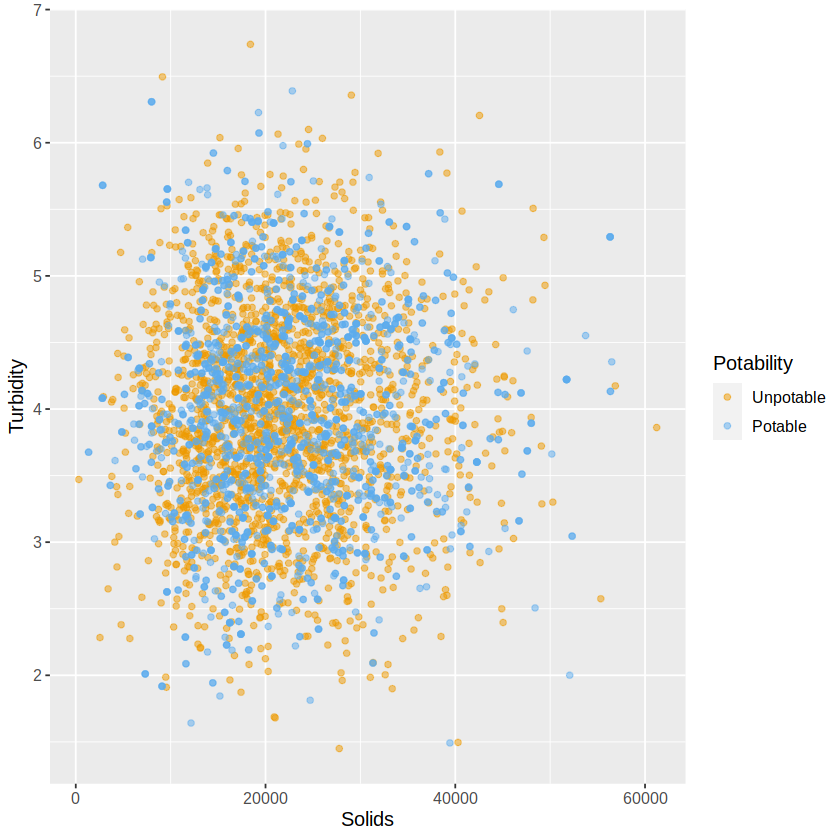

In [7]:
set.seed(1000) 
#Visualizing balanced predictor variables, coloured by Potability
water_pot_pred_plot <- upsampled_water |>
  ggplot(aes(x = Solids, y = Turbidity, color = Potability)) +
  geom_point(alpha = 0.5) +
  labs(color = "Potability") +
  scale_color_manual(values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

water_pot_pred_plot

In [9]:
set.seed(1000) 

#Splitting the data into training and testing sets
water_split <- initial_split(upsampled_water, prop = 0.75, strata = Potability)
water_train <- training(water_split)
water_test <- testing(water_split)

In [10]:
set.seed(1000) 

#Setting tuning specifications and model recipe
water_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

water_recipe <- recipe(Potability ~ Solids + Turbidity, data = water_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [13]:
#K Neighbor Testing sequence
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

#Number of folds
water_vfold <- vfold_cv(water_train, v = 5, strata = Potability)

#Results
knn_results <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_tune) |>
    tune_grid(resamples = water_vfold, grid = k_vals) |>
    collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6779075,5,0.008215887,Preprocessor1_Model01
1,roc_auc,binary,0.6779075,5,0.008215887,Preprocessor1_Model01
2,accuracy,binary,0.6779075,5,0.008215887,Preprocessor1_Model02
2,roc_auc,binary,0.6627587,5,0.009665235,Preprocessor1_Model02
3,accuracy,binary,0.6008082,5,0.012047262,Preprocessor1_Model03
3,roc_auc,binary,0.6408137,5,0.011535538,Preprocessor1_Model03
4,accuracy,binary,0.6008082,5,0.012047262,Preprocessor1_Model04
4,roc_auc,binary,0.6261633,5,0.014241135,Preprocessor1_Model04
5,accuracy,binary,0.5811115,5,0.011475213,Preprocessor1_Model05


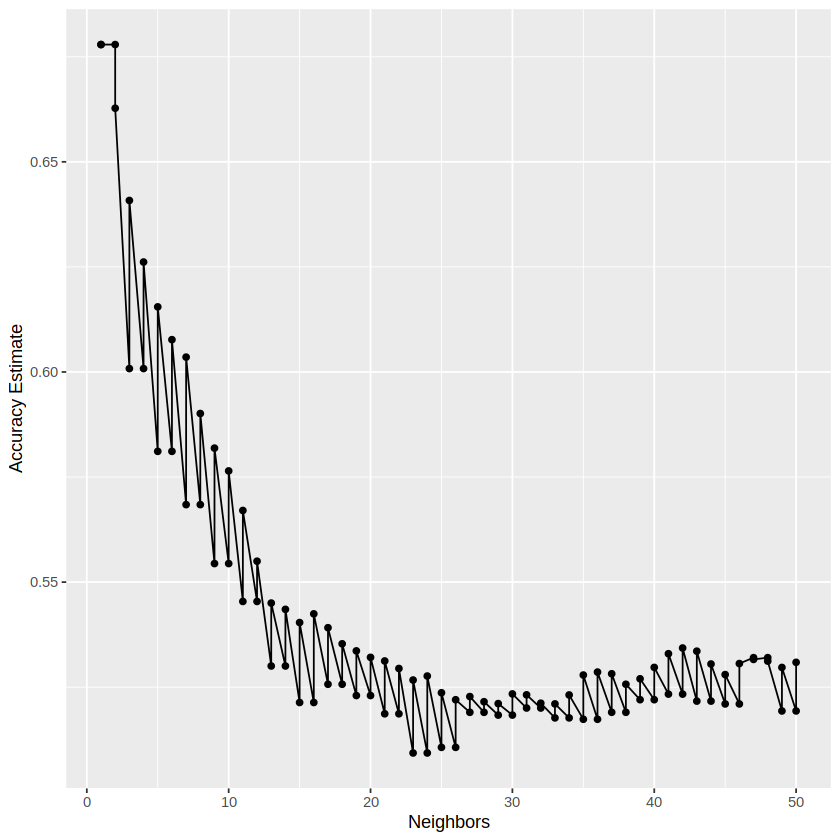

In [15]:
set.seed(1000) 

#Comparing number of neighbours to results
accuracies <- knn_results |>
    filter(.metric == "accuracy")

#Visualizing number of neighbours to accuracy
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
accuracy_versus_k

#K Selection is... 2?

In [17]:
#Determining the accuracy of the model given the chosen neighbors
water_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
       add_recipe(water_recipe) |>
       add_model(water_spec) |>
       fit(data = water_train) 

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3618158
Best kernel: rectangular
Best k: 2

In [19]:
#Table of predictions
water_test_predictions <- predict(knn_fit, water_test) |>
  bind_cols(water_test)

water_test_predictions

.pred_class,Solids,Turbidity,Potability
<fct>,<dbl>,<dbl>,<fct>
Unpotable,19909.542,3.055934,Unpotable
Unpotable,17978.986,4.075075,Unpotable
Unpotable,28748.688,2.559708,Unpotable
Unpotable,32452.614,3.662292,Unpotable
Unpotable,27331.362,4.413974,Unpotable
Unpotable,30980.601,4.268429,Unpotable
Unpotable,21218.703,5.200885,Unpotable
Potable,15193.413,6.038185,Unpotable
Unpotable,15196.230,5.088860,Unpotable


In [20]:
#Accuracy of the model
water_test_predictions |>
  metrics(truth = Potability, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.724


In [26]:
#Confusion matrix of results
confusion <- water_test_predictions |>
             conf_mat(truth = Potability, estimate = .pred_class)
confusion

           Truth
Prediction  Unpotable Potable
  Unpotable       312      88
  Potable         188     412

In [27]:
#Accuracy, precision, and recall of classification model
accuracy <- tibble(accuracy =((312 + 412)/(312+88+188+412)))
precision <- tibble(precision = (312/(312+88)))
recall <- tibble(recall = (312/(312+188)))

accuracy
precision
recall

accuracy
<dbl>
0.724


precision
<dbl>
0.78


recall
<dbl>
0.624
